# Toyota Used Car Market Mispricing Analysis
## From Price Prediction to Market Inefficiency Detection


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#mpl.rcParams.update(mpl.rcParamsDefault)  # 重置为默认设置
plt.rcParams['figure.figsize'] = (10, 6)  # 使用更小的尺寸
plt.rcParams['figure.dpi'] = 100  # 降低分辨率
plt.rcParams['font.size'] = 10
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
# 设置图表样式
sns.set_style("whitegrid")
# 设置图表样式
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [45]:
# 读取数据
data = pd.read_csv(r"E:\项目集\丰田二手车市场洞察\toyota.csv")

In [46]:
# 定义函数：使用IQR检测异常值，并用中位数替换
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[column].median()
    # 识别异常值
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    num_outliers = outliers.sum()
    # 用中位数替换异常值
    df.loc[outliers, column] = median
    print(f"Replaced {num_outliers} outliers in {column} with median {median}")
    return df

# 先处理明显无效值：engineSize <= 0，用中位数替换（或移除，根据需要）
median_engine = data['engineSize'].median()
data.loc[data['engineSize'] <= 0, 'engineSize'] = median_engine
print(f"Replaced invalid engineSize (<=0) with median {median_engine}")

# 应用到关键数值列：year, mileage, price, tax, mpg, engineSize
columns_to_process = ['year', 'mileage', 'price', 'tax', 'mpg', 'engineSize']
for col in columns_to_process:
    data = replace_outliers_with_median(data, col)

# 检查清洗后数据
print("\nAfter outlier replacement:")
print(data.describe())
print(f"Original rows: 6738, After processing: {len(data)} (no rows removed)")

Replaced invalid engineSize (<=0) with median 1.5
Replaced 212 outliers in year with median 2017.0
Replaced 269 outliers in mileage with median 18513.0
Replaced 258 outliers in price with median 10795.0
Replaced 3 outliers in tax with median 135.0
Replaced 208 outliers in mpg with median 62.8
Replaced 2 outliers in engineSize with median 1.5

After outlier replacement:
              year         price       mileage          tax          mpg  \
count  6738.000000   6738.000000   6738.000000  6738.000000  6738.000000   
mean   2017.007717  11724.086227  20259.761057    94.510982    62.658638   
std       1.581003   4848.218102  13986.988428    73.248500    11.361443   
min    2013.000000    850.000000      2.000000     0.000000    35.300000   
25%    2016.000000   8290.000000   9446.000000     0.000000    56.500000   
50%    2017.000000  10795.000000  18512.500000   135.000000    62.800000   
75%    2018.000000  13990.000000  28755.500000   145.000000    69.000000   
max    2020.000000  

In [47]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [49]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2017.007717,11724.086227,20259.761057,94.510982,62.658638,1.471787
std,1.581003,4848.218102,13986.988428,73.248500,11.361443,0.431092
min,2013.000000,850.000000,2.000000,0.000000,35.300000,1.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,56.500000,1.000000
50%,2017.000000,10795.000000,18512.500000,135.000000,62.800000,1.500000
75%,2018.000000,13990.000000,28755.500000,145.000000,69.000000,1.800000
max,2020.000000,25000.000000,63475.000000,330.000000,86.000000,3.000000


In [50]:
print(data['model'].value_counts())

model
Yaris            2122
Aygo             1961
Auris             712
C-HR              479
RAV4              473
Corolla           267
Prius             232
Avensis           115
Verso             114
Hilux              86
GT86               73
Land Cruiser       51
PROACE VERSO       15
Supra              12
Camry              11
IQ                  8
Urban Cruiser       4
Verso-S             3
Name: count, dtype: int64


In [51]:
print(data['fuelType'].value_counts())

fuelType
Petrol    4087
Hybrid    2043
Diesel     503
Other      105
Name: count, dtype: int64


In [52]:
print(data['transmission'].value_counts())

transmission
Manual       3826
Automatic    2657
Semi-Auto     254
Other           1
Name: count, dtype: int64


In [53]:
print("原始数据中的车型种类:", data['model'].unique())
print("车型数量:", len(data['model'].unique()))

# 检查映射字典的键
model_mapping = {model: idx for idx, model in enumerate(data['model'].unique())}
print("映射字典的键:", model_mapping.keys())
print("映射字典键的数量:", len(model_mapping))

原始数据中的车型种类: [' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser']
车型数量: 18
映射字典的键: dict_keys([' GT86', ' Corolla', ' RAV4', ' Yaris', ' Auris', ' Aygo', ' C-HR', ' Prius', ' Avensis', ' Verso', ' Hilux', ' PROACE VERSO', ' Land Cruiser', ' Supra', ' Camry', ' Verso-S', ' IQ', ' Urban Cruiser'])
映射字典键的数量: 18


In [54]:
data1 = data[['price','year','mileage','tax','mpg','engineSize']]

In [55]:
data1

,price,year,mileage,tax,mpg,engineSize
0,16000,2016,24089,265,36.2,2.0
1,15995,2017,18615,145,36.2,2.0
2,13998,2015,27469,265,36.2,2.0
3,18998,2017,14736,150,36.2,2.0
4,17498,2017,36284,145,36.2,2.0
...,...,...,...,...,...,...
6733,5500,2017,30000,20,58.9,1.0
6734,4985,2017,36154,125,50.4,1.3
6735,4995,2017,46000,125,57.6,1.4
6736,3995,2017,60700,125,50.4,1.3


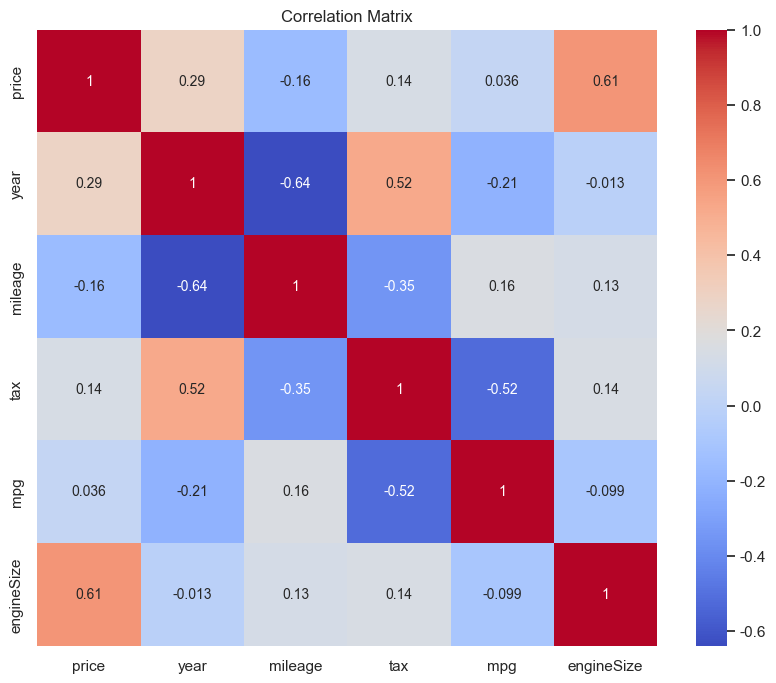

In [56]:
plt.figure(figsize=(10,8))
sns.heatmap(data1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

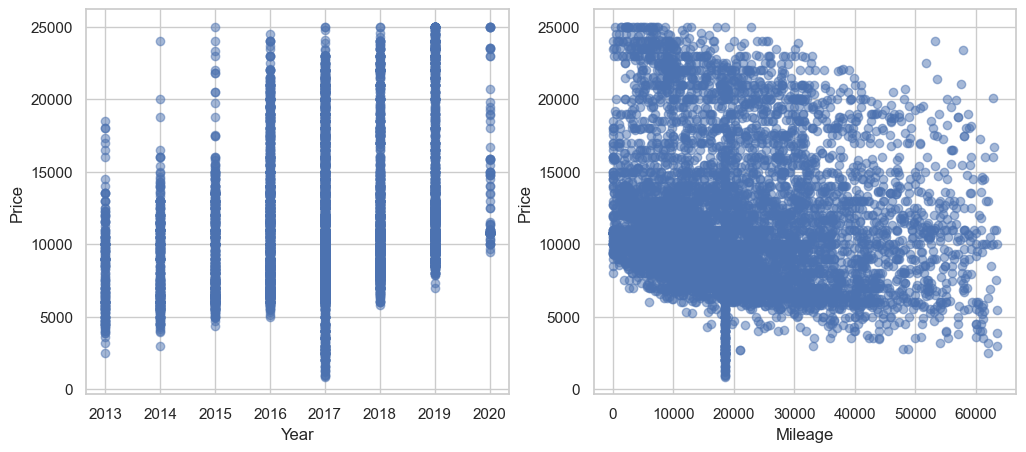

In [57]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(data['year'], data['price'], alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Price')

plt.subplot(1, 2, 2)
plt.scatter(data['mileage'], data['price'], alpha=0.5)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

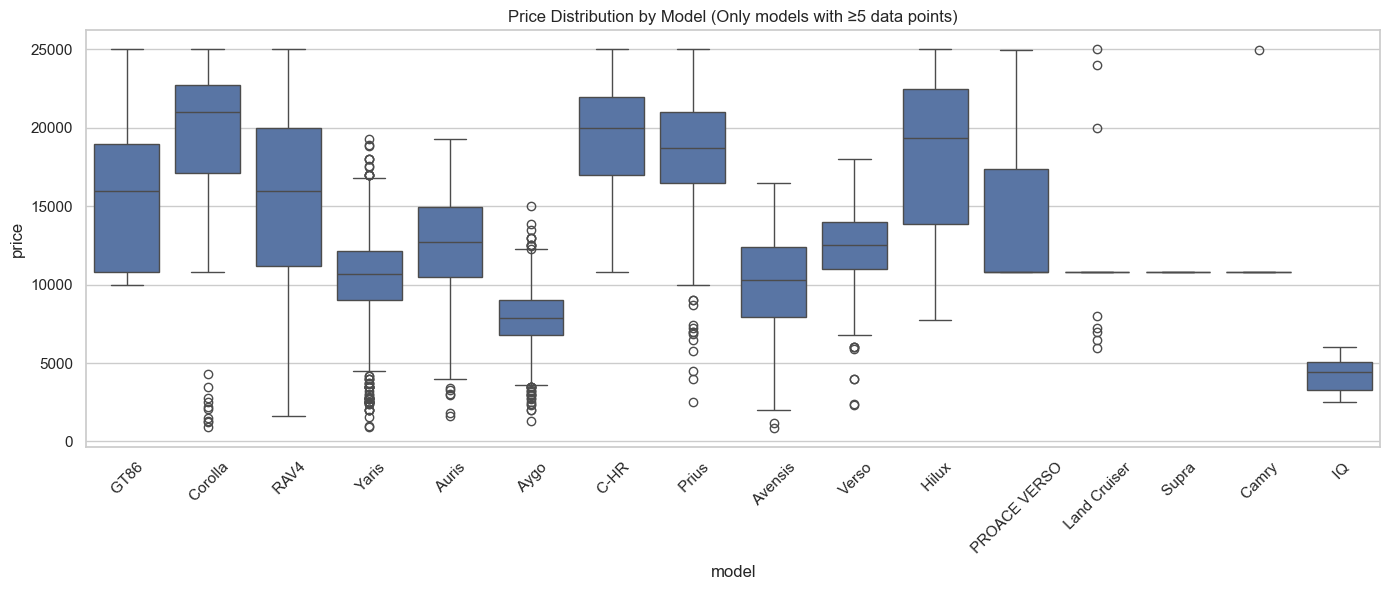

In [58]:
# 过滤掉数据量太少的车型
model_counts = data['model'].value_counts()
valid_models = model_counts[model_counts >= 5].index  # 只保留至少有5个数据点的车型
filtered_data = data[data['model'].isin(valid_models)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_data, x='model', y='price')
plt.xticks(rotation=45)
plt.title('Price Distribution by Model (Only models with ≥5 data points)')
plt.tight_layout()
plt.show()

In [59]:
data_price = data.copy()
numerical_features = [
    'year', 
    'mileage', 
    'tax', 
    'mpg', 
    'engineSize'
]

categorical_features = [
    'fuelType', 
    'transmission', 
    'model'
]

X = data_price[numerical_features + categorical_features]
y = data_price['price']
# 对类别变量做 One-Hot 编码
X = pd.get_dummies(
    X,
    columns=categorical_features,
    drop_first=True
)
X.shape
X.columns[:10]
X.head()

,year,mileage,tax,mpg,engineSize,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Other,...,model_ IQ,model_ Land Cruiser,model_ PROACE VERSO,model_ Prius,model_ RAV4,model_ Supra,model_ Urban Cruiser,model_ Verso,model_ Verso-S,model_ Yaris
0,2016,24089,265,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2017,18615,145,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,2015,27469,265,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2017,14736,150,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2017,36284,145,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print("Train R²:", rf.score(X_train, y_train))
print("Test  R²:", rf.score(X_test, y_test))

Train R²: 0.9723001773663884
Test  R²: 0.8661582249905235


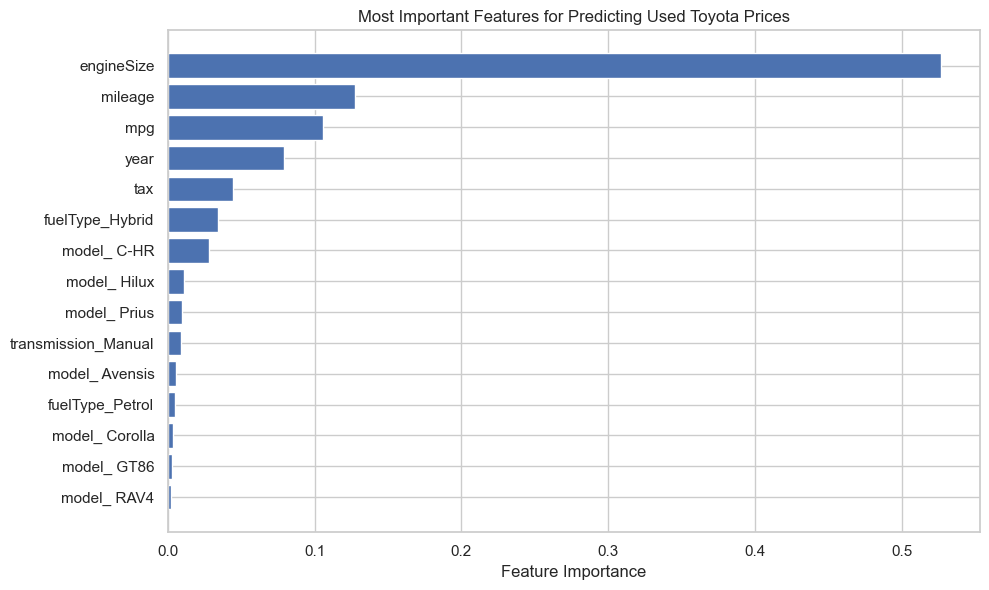

In [61]:
# 确保特征名是从 One-Hot 编码后的 X 中获取的

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)


top_n = 15

plt.figure(figsize=(10,6))
plt.barh(
    importance_df['feature'][:top_n][::-1],
    importance_df['importance'][:top_n][::-1]
)
plt.xlabel('Feature Importance')
plt.title('Most Important Features for Predicting Used Toyota Prices')
plt.tight_layout()
plt.show()

plt.show()

In [62]:
#因为数据中2020为最新年份，所以计算车龄时用2021减去年份
data_price['age'] = 2020 - data_price['year']

# 选择特征：车龄、里程、油耗、发动机排量、燃油类型、车型
numerical_features = [
    'age', 
    'mileage', 
    'tax', 
    'mpg', 
    'engineSize'
]

categorical_features = [
    'fuelType', 
    'transmission', 
    'model'
]

X = data_price[numerical_features + categorical_features]
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = data_price['price']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用随机森林模型
rf_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 用模型预测价格
data_price['predicted_price'] = rf_model.predict(X)

In [63]:
# 计算保值率（实际价格 / 预测价格）
data_price['mispricing_index'] = data_price['price'] / data_price['predicted_price']

In [64]:
# 按车型分组，计算平均保值率
residual_by_model = data_price.groupby('model').agg({
    'mispricing_index': 'mean',
    'price': 'mean',
    'age': 'mean',
    'mileage': 'mean'
})

# 筛选样本量足够的车型（>30辆）
residual_by_model = residual_by_model[residual_by_model['mispricing_index'].notna()]
residual_by_model = residual_by_model.sort_values('mispricing_index', ascending=False)

# 添加样本量字段
residual_by_model['sample_size'] = data_price.groupby('model').size()

# 只保留样本量 > 30 的车型
residual_by_model = residual_by_model[residual_by_model['sample_size'] >= 30]

# 展示保值率排名
residual_by_model[['mispricing_index', 'sample_size']].head(10)

,mispricing_index,sample_size
model,,
Land Cruiser,1.023119,51
Prius,1.001987,232
Verso,1.000051,114
Aygo,0.998574,1961
Yaris,0.997282,2122
RAV4,0.996693,473
Auris,0.995463,712
Corolla,0.993737,267
C-HR,0.990049,479


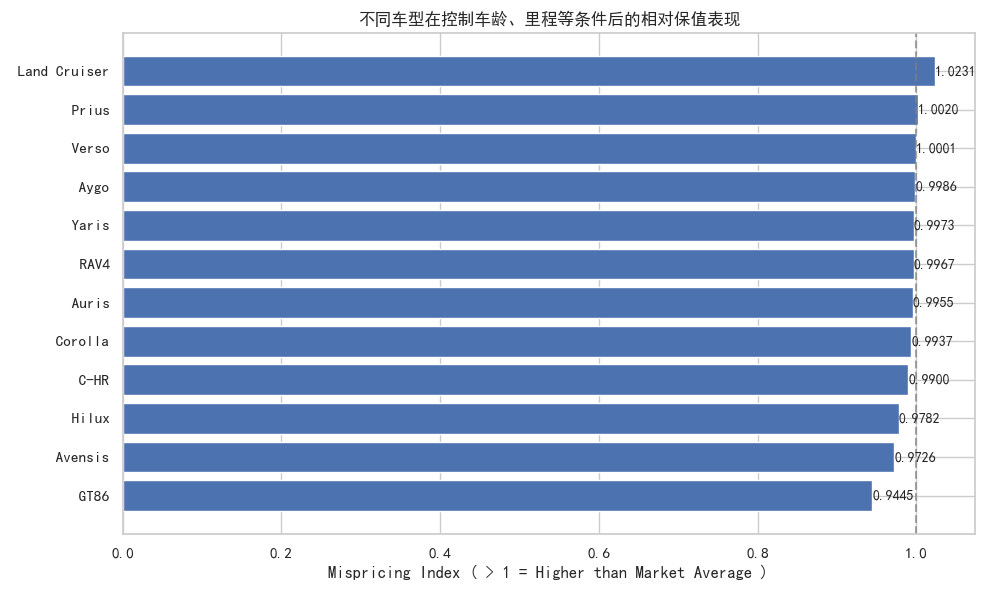

In [65]:
plt.figure(figsize=(10,6))
bars = plt.barh(
    residual_by_model.index,
    residual_by_model['mispricing_index']
)

# 在每个条形上添加数值
for bar in bars:
    width = bar.get_width()  # 获取条形的宽度，即mispricing_index值
    plt.text(width, bar.get_y() + bar.get_height() / 2, 
             f'{width:.4f}',  # 格式化为4位小数
             va='center', ha='left', fontsize=10)

# 添加一条分界线
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.axvline(1.0, linestyle='--', color='gray', alpha=0.7)  # 分界线：1.0表示市场平均保值率
plt.xlabel('Mispricing Index ( > 1 = Higher than Market Average )')
plt.title('不同车型在控制车龄、里程等条件后的相对保值表现')
plt.gca().invert_yaxis()  # 使得最重要的车型显示在顶部
plt.tight_layout()
plt.show()

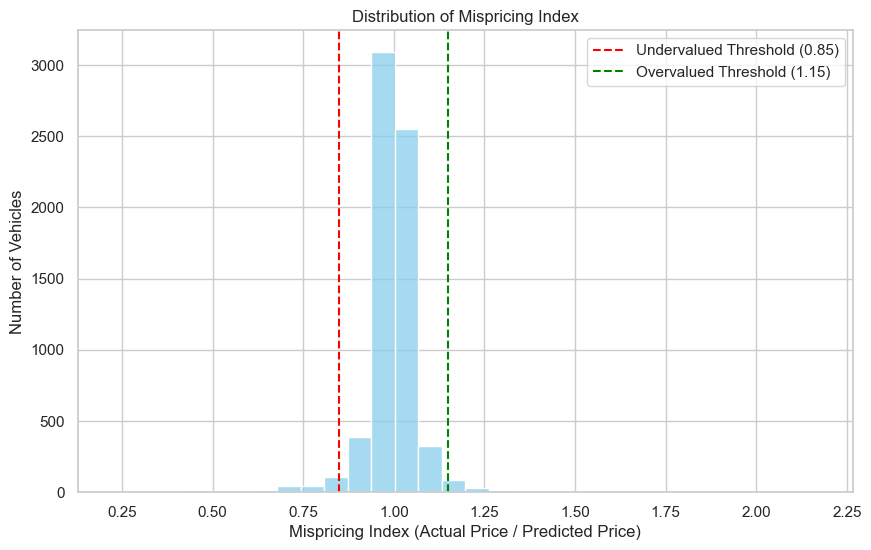

In [66]:
# 设置绘图风格
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.histplot(data_price['mispricing_index'], bins=30, kde=False, color='skyblue')

# 添加 0.85 和 1.15 分界线
plt.axvline(x=0.85, color='red', linestyle='--', label='Undervalued Threshold (0.85)')
plt.axvline(x=1.15, color='green', linestyle='--', label='Overvalued Threshold (1.15)')

plt.title('Distribution of Mispricing Index')
plt.xlabel('Mispricing Index (Actual Price / Predicted Price)')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()


In [67]:
# 统计低估、高估、合理车辆数量
total = len(data_price)
undervalued = len(data_price[data_price['mispricing_index'] < 0.85])
overvalued = len(data_price[data_price['mispricing_index'] > 1.15])
fair = total - undervalued - overvalued

# 打印比例
print(f"Total vehicles: {total}")
print(f"Undervalued (<0.85): {undervalued} ({undervalued/total:.2%})")
print(f"Overvalued (>1.15): {overvalued} ({overvalued/total:.2%})")
print(f"Fairly priced (0.85~1.15): {fair} ({fair/total:.2%})")


Total vehicles: 6738
Undervalued (<0.85): 190 (2.82%)
Overvalued (>1.15): 117 (1.74%)
Fairly priced (0.85~1.15): 6431 (95.44%)


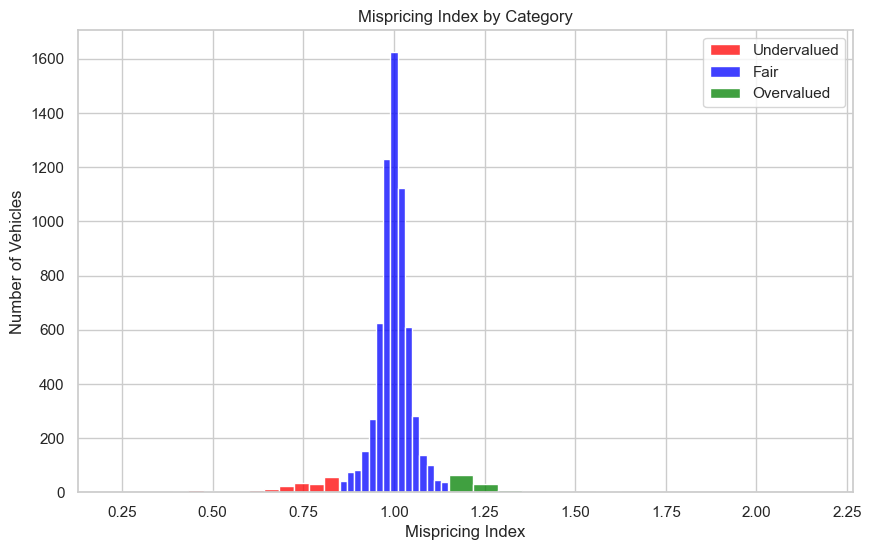

In [68]:
plt.figure(figsize=(10,6))
sns.histplot(data_price[data_price['mispricing_index'] < 0.85]['mispricing_index'], bins=15, color='red', label='Undervalued')
sns.histplot(data_price[(data_price['mispricing_index'] >= 0.85) & (data_price['mispricing_index'] <= 1.15)]['mispricing_index'], bins=15, color='blue', label='Fair')
sns.histplot(data_price[data_price['mispricing_index'] > 1.15]['mispricing_index'], bins=15, color='green', label='Overvalued')

plt.title('Mispricing Index by Category')
plt.xlabel('Mispricing Index')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()


In [69]:
# 按车型分组计算平均 mispricing_index
model_mispricing = data_price.groupby('model')['mispricing_index'].mean().sort_values(ascending=False)

# 查看前10高估车型和前10低估车型
print("Top 10 Overvalued Models:")
print(model_mispricing.head(10))
print("\nTop 10 Undervalued Models:")
print(model_mispricing.tail(10))


Top 10 Overvalued Models:
model
Land Cruiser    1.023119
Verso-S         1.008485
Prius           1.001987
Verso           1.000051
Aygo            0.998574
Yaris           0.997282
RAV4            0.996693
Auris           0.995463
Corolla         0.993737
Supra           0.990866
Name: mispricing_index, dtype: float64

Top 10 Undervalued Models:
model
Corolla          0.993737
Supra            0.990866
C-HR             0.990049
Hilux            0.978194
PROACE VERSO     0.976772
Avensis          0.972606
Camry            0.957978
Urban Cruiser    0.947564
GT86             0.944475
IQ               0.931224
Name: mispricing_index, dtype: float64


C:\Users\lenovo\AppData\Local\Temp\ipykernel_35752\120982314.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_mispricing.index, y=model_mispricing.values, palette=colors)


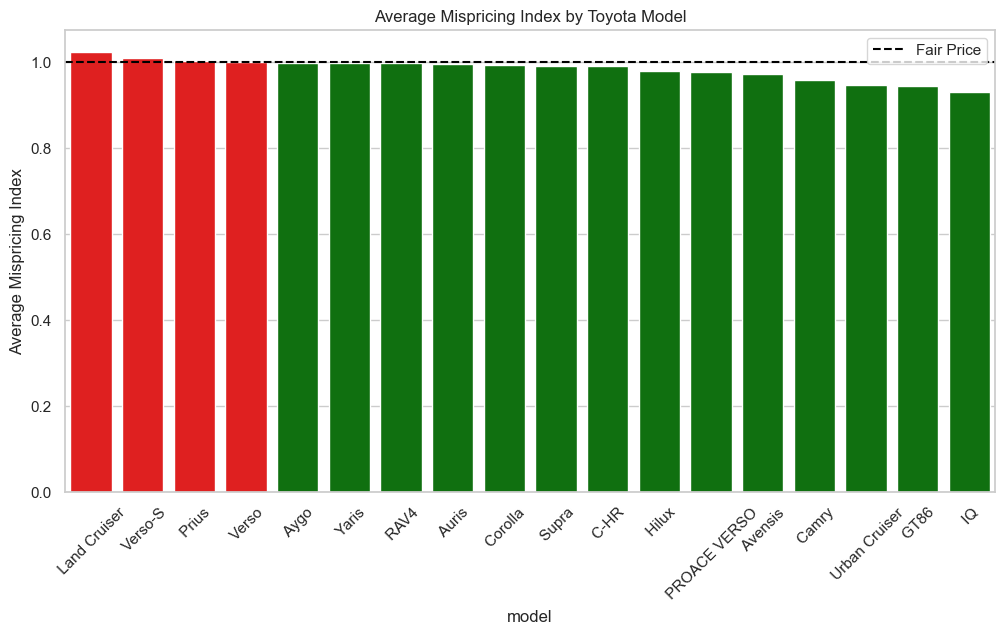

In [70]:
# 给颜色分类
colors = ['green' if x < 1 else 'red' for x in model_mispricing.values]

plt.figure(figsize=(12,6))
sns.barplot(x=model_mispricing.index, y=model_mispricing.values, palette=colors)
plt.axhline(1, color='black', linestyle='--', label='Fair Price')
plt.xticks(rotation=45)
plt.ylabel('Average Mispricing Index')
plt.title('Average Mispricing Index by Toyota Model')
plt.legend()
plt.show()


In [71]:
# 先确保已经有 age 列，如果没有可以创建
data_price['age'] = 2020 - data_price['year']  # 或者用你的数据年份列

# 计算透视表：车型 × 车龄
heatmap_data = data_price.pivot_table(
    index='model', 
    columns='age', 
    values='mispricing_index', 
    aggfunc='mean'
)

# 查看前几行
heatmap_data.head()


age,0,1,2,3,4,5,6,7
model,,,,,,,,
Auris,NaN,0.970435,0.993489,0.991473,0.999858,0.999881,0.993635,0.997953
Avensis,NaN,NaN,1.017851,0.938593,0.983916,1.030038,0.991614,0.992585
Aygo,1.010076,0.997296,1.001284,0.997080,0.999554,0.998000,0.998150,0.999867
C-HR,0.925984,0.961376,1.004906,0.998095,0.992119,NaN,NaN,NaN
Camry,0.958009,0.957975,NaN,NaN,NaN,NaN,NaN,NaN


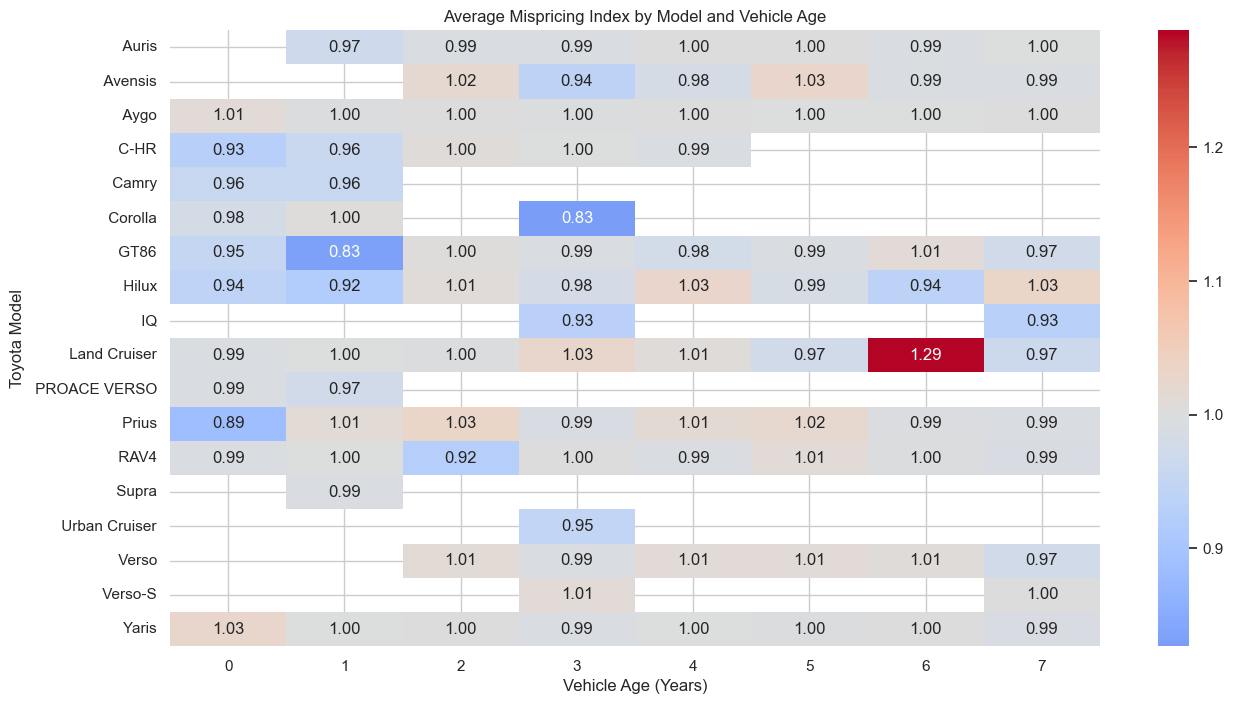

In [72]:
plt.figure(figsize=(15,8))
sns.heatmap(
    heatmap_data, 
    annot=True,           # 显示数值
    fmt=".2f",            # 保留两位小数
    cmap="coolwarm",      # 蓝-白-红，低估-合理-高估
    center=1               # 以 1 为中线，颜色中心
)

plt.title('Average Mispricing Index by Model and Vehicle Age')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Toyota Model')
plt.show()


In [73]:
# 新增 buy_signal 列：True 表示建议收购
data_price['buy_signal'] = data_price['mispricing_index'] < 0.85

# 计算建议收购的车辆数量
buy_count = data_price['buy_signal'].sum()
total_count = len(data_price)
print(f"Total vehicles: {total_count}")
print(f"Suggested to buy: {buy_count} ({buy_count/total_count:.2%})")


Total vehicles: 6738
Suggested to buy: 190 (2.82%)


In [74]:
# 只有建议收购的车辆计算潜在利润
data_price['potential_profit'] = data_price['predicted_price'] - data_price['price']

# 策略下平均潜在利润
avg_profit = data_price.loc[data_price['buy_signal'], 'potential_profit'].mean()
total_profit = data_price.loc[data_price['buy_signal'], 'potential_profit'].sum()

print(f"Average potential profit per vehicle: £{avg_profit:.2f}")
print(f"Total potential profit if all recommended vehicles are bought: £{total_profit:.2f}")


Average potential profit per vehicle: £3216.38
Total potential profit if all recommended vehicles are bought: £611111.70


C:\Users\lenovo\AppData\Local\Temp\ipykernel_35752\1993504421.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='buy_signal', data=data_price, palette=['red','green'])


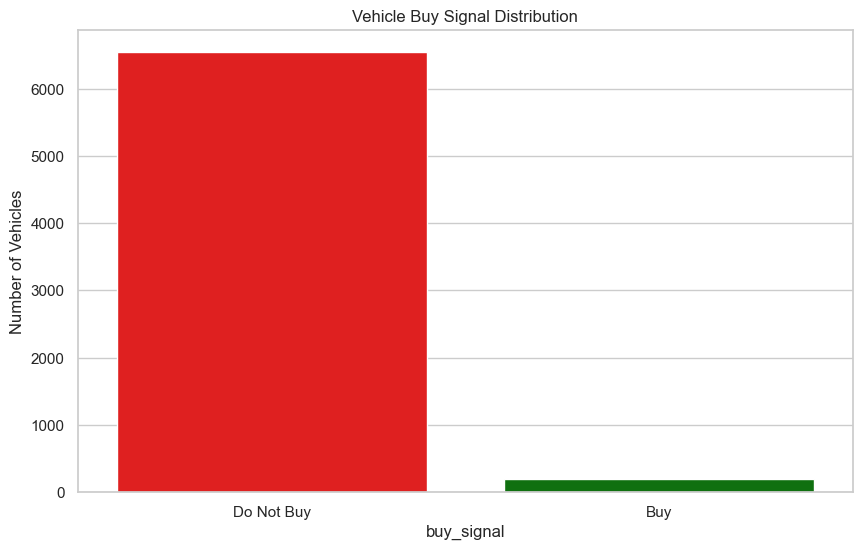

In [75]:
plt.figure(figsize=(10,6))
sns.countplot(x='buy_signal', data=data_price, palette=['red','green'])
plt.xticks([0,1], ['Do Not Buy','Buy'])
plt.ylabel('Number of Vehicles')
plt.title('Vehicle Buy Signal Distribution')
plt.show()


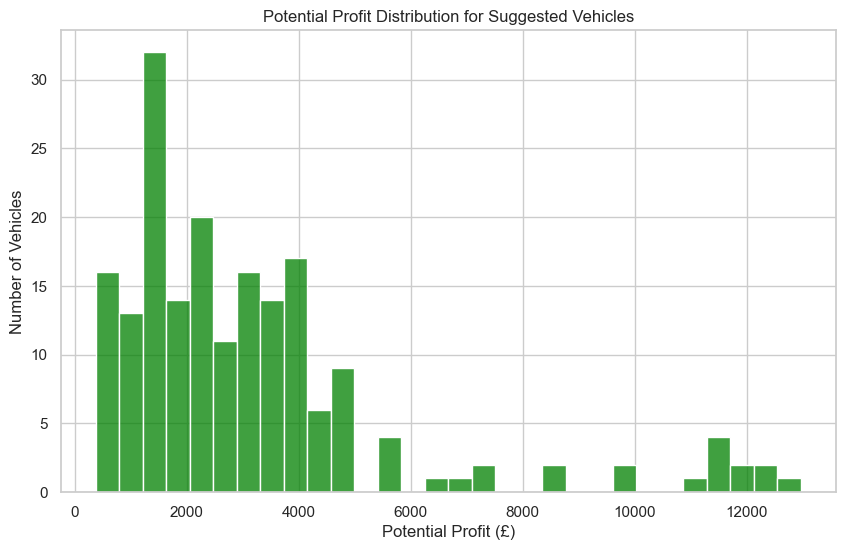

In [76]:
plt.figure(figsize=(10,6))
sns.histplot(data_price.loc[data_price['buy_signal'], 'potential_profit'], bins=30, color='green')
plt.title('Potential Profit Distribution for Suggested Vehicles')
plt.xlabel('Potential Profit (£)')
plt.ylabel('Number of Vehicles')
plt.show()


In [77]:
profit_by_model = data_price[data_price['buy_signal']].groupby('model')['potential_profit'].mean().sort_values(ascending=False)
print(profit_by_model.head(10))


model
GT86            7972.731616
PROACE VERSO    6596.241667
Hilux           5089.411681
C-HR            4754.741616
Corolla         3677.817655
Camry           3221.241667
Prius           2608.241985
RAV4            2523.705704
Auris           2307.284020
Avensis         1791.522917
Name: potential_profit, dtype: float64


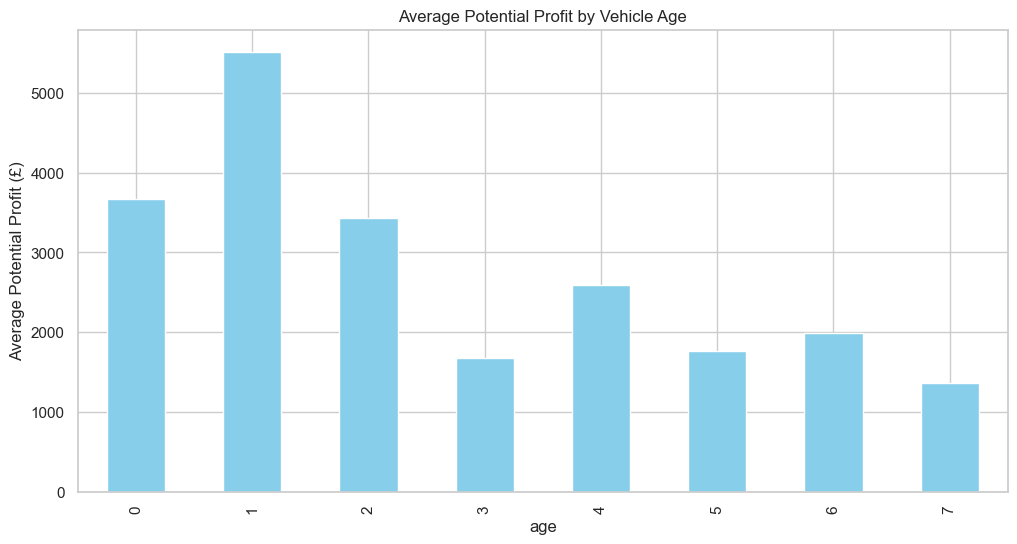

In [78]:
profit_by_age = data_price[data_price['buy_signal']].groupby('age')['potential_profit'].mean()
profit_by_age.plot(kind='bar', figsize=(12,6), color='skyblue')
plt.ylabel('Average Potential Profit (£)')
plt.title('Average Potential Profit by Vehicle Age')
plt.show()


 ​市场趋势：市场是否系统性高估或低估某些车型？

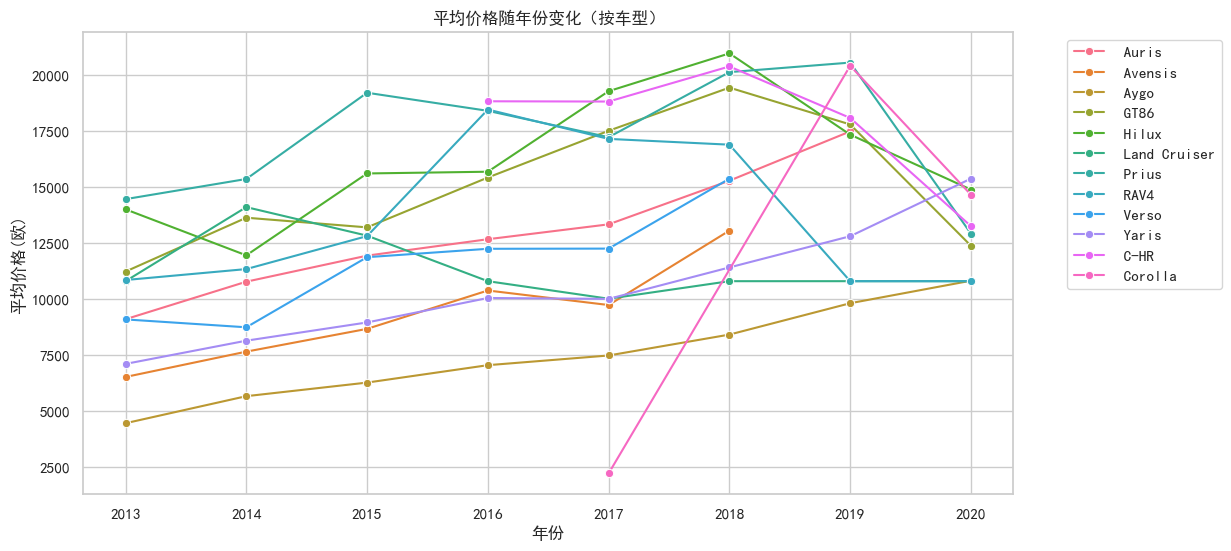

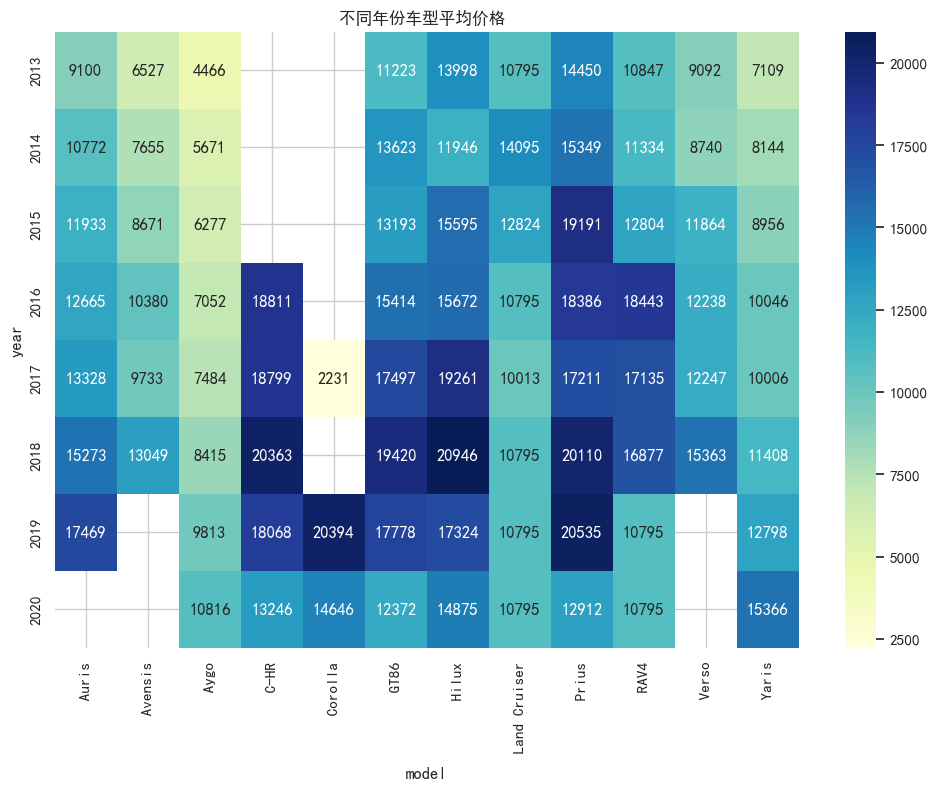

              mean   median   min    max  count
year                                           
2013   8333.308824   8394.5  2470  18495    204
2014   8870.863636   8990.0  2991  23995    352
2015   9674.600000   9000.0  4350  24995    525
2016  11641.295888  10795.0  5000  24500    997
2017  11388.725684   9995.0   850  25000   2231
2018  12241.916256  10698.0  5790  24995   1015
2019  13979.583204  11988.0  6999  25000   1286
2020  13103.757812  10795.0  9480  25000    128


In [79]:
# 过滤主要车型 (>50样本)
main_models = data['model'].value_counts()[data['model'].value_counts() > 50].index
trend_data = data[data['model'].isin(main_models)]

# 按年份/车型平均价格
price_by_year_model = trend_data.groupby(['year', 'model'])['price'].agg(['mean', 'count']).reset_index()

# 线图：价格趋势
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'times new roman']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_by_year_model, x='year', y='mean', hue='model', marker='o')
plt.title('平均价格随年份变化（按车型）')
plt.xlabel('年份')
plt.ylabel('平均价格(欧)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 热力图
pivot = price_by_year_model.pivot(index='year', columns='model', values='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('不同年份车型平均价格 ')
plt.show()

# 洞察表：年份价格分布
year_summary = data.groupby('year')['price'].agg(['mean', 'median', 'min', 'max', 'count'])
print(year_summary)

<Figure size 800x500 with 0 Axes>

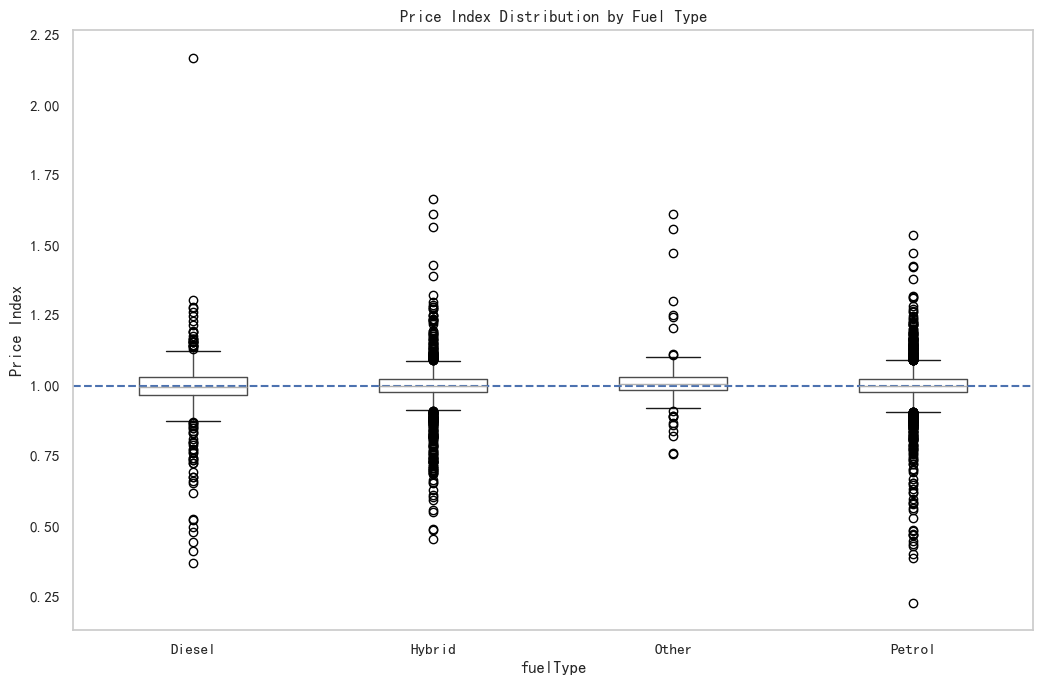

In [82]:
plt.figure(figsize=(8,5))
data_price.boxplot(
    column='mispricing_index',
    by='fuelType',
    grid=False
)
plt.axhline(1.0, linestyle='--')
plt.title('Price Index Distribution by Fuel Type')
plt.suptitle('')
plt.ylabel('Price Index')
plt.show()